<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/timestamp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [78]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_4.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 1000

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 3

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

###1.1

In [2]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26114 sha256=a1fa5c5d4563394ade8656514f8e45c3d8e7f40b868b6a4300a5ea6f87cb3dd5
  Stored in directory: /root/.cache/pip/wheels/ab/fa/1b/75d9a713279796785711bd0bad8334aaace560c0bd28830c8c
  Created wheel for stringdist: filename=StringDist-1.0.9-cp39-cp39-linux_x86_64.whl size=24711 sha256=0658afa7fae1e501905bc1b9cd31be4b75ff6d508b8c449b0428d2361606ef77
  Stored in directory: /root/.cache/pip/wheels/77/24/44/b12b9612fd07e141e6b4f1bb2001c621515bd0cac1014a783a
Successfully built intervaltree stringdist
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.7 MB/s eta 0:00:00


In [79]:
from google.colab import auth
auth.authenticate_user()

In [80]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [81]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [82]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,108811,Left ICU,2170-08-16 14:02:15
1,108811,Left ICU,2170-08-19 11:28:19
2,153771,Left ICU,2166-07-25 15:19:16
3,155415,Left ICU,2163-07-27 21:53:00
4,188869,Left ICU,2170-06-22 18:49:28
...,...,...,...
175609,109352,Discharged,2167-04-16 17:10:00
175610,166032,Discharged,2198-09-20 21:16:00
175611,120514,Discharged,2163-09-09 17:30:00
175612,175280,Discharged,2204-01-25 14:20:00


## Section 2: Process Discovery

In [83]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-83-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Number of cases: 42652
Number of events: 175612
Start events: {'Admitted': 41946, 'Entered ICU': 650, 'Discharged': 56}
End events: {'Discharged': 35137, 'Left ICU': 7510, 'Admitted': 5}


In [84]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
# filtered_log = deepcopy(event_log)
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
# event_log = pm.filter_variants_top_k(event_log,50)
# event_log = pm.filter_variants_by_coverage_percentage(event_log, 0.1)

In [85]:
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 34516
Number of events: 141410
Start events: {'Admitted': 34516}
End events: {'Discharged': 34516}


In [86]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

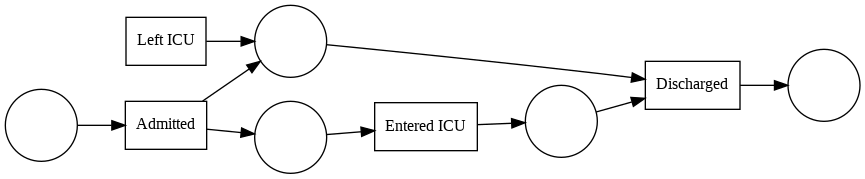

In [87]:
import graphviz
pm.view_petri_net(petri_net=net)

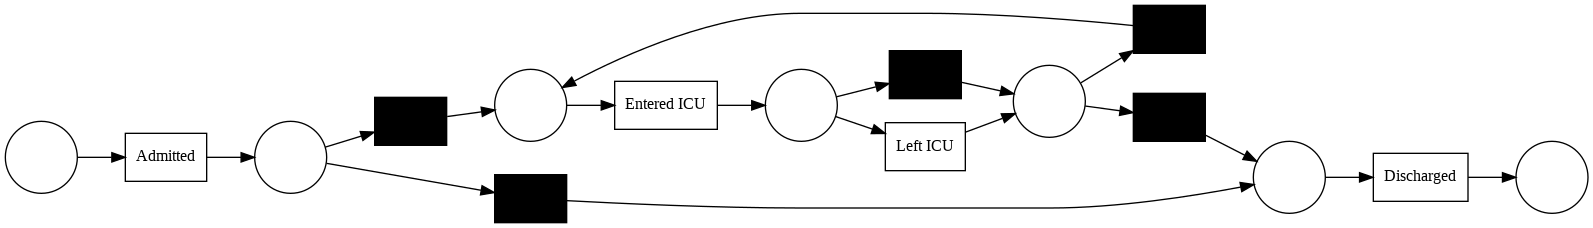

In [88]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

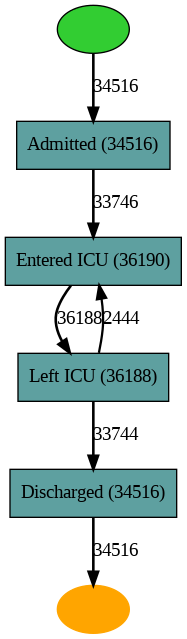

In [89]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

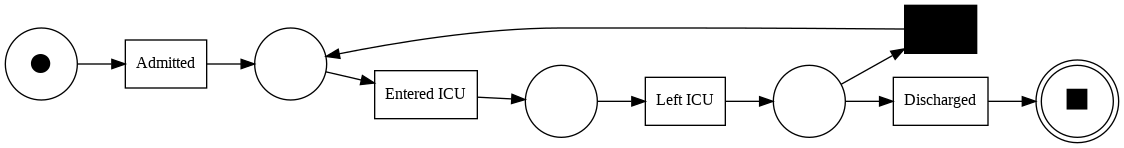

In [90]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

##Section 3: Preprocessing Data

In [91]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  # random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = el[el['trace'].isin(random_traces)]
  return partial_el


In [92]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,trace,activity,timestamp
112,27,Admitted,2129-03-04 10:55:00
113,27,Entered ICU,2129-03-04 10:55:42
114,27,Left ICU,2129-03-05 13:25:26
115,27,Discharged,2129-03-06 12:30:00
236,58,Admitted,2115-01-20 17:01:00
...,...,...,...
141191,34464,Discharged,2197-03-16 18:40:00
141342,34499,Admitted,2181-04-07 10:52:00
141343,34499,Entered ICU,2181-04-07 10:53:54
141344,34499,Left ICU,2181-04-08 21:17:17


In [93]:
# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
n_activities = len(unique_activities) + 1
encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}
encode_activity, decode_activity

({'Admitted': '1', 'Entered ICU': '2', 'Left ICU': '3', 'Discharged': '4'},
 {'1': 'Admitted', '2': 'Entered ICU', '3': 'Left ICU', '4': 'Discharged'})

In [94]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]
test_el

,trace,activity,timestamp
780,189,Admitted,2196-12-02 12:00:00
781,189,Entered ICU,2196-12-03 20:12:41
782,189,Left ICU,2196-12-06 18:13:52
783,189,Discharged,2196-12-11 16:00:00
2218,539,Admitted,2165-09-13 07:15:00
...,...,...,...
140151,34210,Discharged,2164-01-10 16:44:00
141342,34499,Admitted,2181-04-07 10:52:00
141343,34499,Entered ICU,2181-04-07 10:53:54
141344,34499,Left ICU,2181-04-08 21:17:17


In [95]:
# find the first timestamp in dataset
# start_time = partial_el['timestamp'].min()

In [96]:
import numpy as np

# transform train data into prefix, suffix and label
def label_train(el):
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr, label_times_arr = [], [], [], [], [], []
  start_times, end_times = [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  
  for t in unique_traces:
    df = el[:][el.trace == t].sort_values(by='timestamp')
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)
      timestamp = df['timestamp'][i]
      # timestamp = (df['timestamp'][i] - start_time).total_seconds() / 10_000_000_000
      timestamps.append(timestamp)
    
    start_time = timestamps[0]
    end_time = timestamps[-1]
    length = len(activities)
    
    for i in range(length):
      timestamps[i] = (timestamps[i] - start_time).total_seconds()  / 3600 / 1000
    

    for i in range(length):
      label = activities[i]
      time_label = timestamps[i]
      prefix = activities[:i]
      prefix_times = timestamps[:i]

      suffix = []
      suffix_times = []

      if i != length - 1:
        suffix = activities[i+1:]
        suffix_times = timestamps[i+1:]

      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      padding = []
      
      while len(prefix_times) + len(padding) < PREFIX_LENGTH:
        padding.append(0.0)
      
      prefix_times =  padding + prefix_times

      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      while len(suffix_times) < PREFIX_LENGTH:
        suffix_times.append(0.0)
      
      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      prefix_times_arr.append(np.array(prefix_times[0:PREFIX_LENGTH]))
      suffix_times_arr.append(np.array(suffix_times[0:PREFIX_LENGTH]))
      label_arr.append(label)
      label_times_arr.append(time_label)
      start_times.append(start_time)
      end_times.append(end_time)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix times' : prefix_times_arr,
                       'suffix times' : suffix_times_arr,
                       'activity label' : label_arr,
                       'time label': label_times_arr,
                       'start times': start_times,
                       'end times': end_times
                       })
  

labeled_train_el = label_train(train_el)
labeled_train_el

,prefix,suffix,prefix times,suffix times,activity label,time label,start times,end times
0,"[0, 0, 0]","[2, 3, 4]","[0.0, 0.0, 0.0]","[1.1666666666666668e-05, 0.02650722222222222, ...",1,0.000000,2129-03-04 10:55:00,2129-03-06 12:30:00
1,"[0, 0, 1]","[3, 4, 0]","[0.0, 0.0, 0.0]","[0.02650722222222222, 0.04958333333333333, 0.0]",2,0.000012,2129-03-04 10:55:00,2129-03-06 12:30:00
2,"[0, 1, 2]","[4, 0, 0]","[0.0, 0.0, 1.1666666666666668e-05]","[0.04958333333333333, 0.0, 0.0]",3,0.026507,2129-03-04 10:55:00,2129-03-06 12:30:00
3,"[1, 2, 3]","[0, 0, 0]","[0.0, 1.1666666666666668e-05, 0.02650722222222...","[0.0, 0.0, 0.0]",4,0.049583,2129-03-04 10:55:00,2129-03-06 12:30:00
4,"[0, 0, 0]","[2, 3, 4]","[0.0, 0.0, 0.0]","[3.555555555555555e-05, 0.04894055555555556, 0...",1,0.000000,2115-01-20 17:01:00,2115-01-31 16:30:00
...,...,...,...,...,...,...,...,...
3227,"[1, 2, 3]","[0, 0, 0]","[0.0, 0.04369194444444444, 0.17531083333333333]","[0.0, 0.0, 0.0]",4,0.812567,2183-07-27 09:56:00,2183-08-30 06:30:00
3228,"[0, 0, 0]","[2, 3, 4]","[0.0, 0.0, 0.0]","[1.6944444444444446e-05, 0.13672416666666667, ...",1,0.000000,2197-03-10 00:28:00,2197-03-16 18:40:00
3229,"[0, 0, 1]","[3, 4, 0]","[0.0, 0.0, 0.0]","[0.13672416666666667, 0.16219999999999998, 0.0]",2,0.000017,2197-03-10 00:28:00,2197-03-16 18:40:00
3230,"[0, 1, 2]","[4, 0, 0]","[0.0, 0.0, 1.6944444444444446e-05]","[0.16219999999999998, 0.0, 0.0]",3,0.136724,2197-03-10 00:28:00,2197-03-16 18:40:00


In [97]:
labeled_train_el['time label'].max()

2.582516666666667

In [98]:
labeled_train_el, validation_el = train_test_split(labeled_train_el, test_size=VALIDATION_SIZE, random_state=9)

In [135]:
def format_input(el):
  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  start_times = np.array(el['start times'])

  prefix_t = np.array(el['prefix times'])
  suffix_t = np.array(el['suffix times'])

   
  prefix_t = np.stack(prefix_t)
  prefix_t = prefix_t.reshape(prefix_t.shape[0], prefix_t.shape[1], 1)

  suffix_t = np.stack(suffix_t)
  suffix_t = suffix_t.reshape(suffix_t.shape[0], suffix_t.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x], [prefix_t], [suffix_t]))

  y = np.array(el['time label'])
  y = np.stack(y)

  return x, y, start_times

In [136]:
train_x, train_y, _ = format_input(labeled_train_el)
validation_x, validation_y, _ = format_input(validation_el)
# validation_x

In [114]:
from copy import deepcopy

def random_remove(el):
  unique_traces_test = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces_test}
  df = pd.DataFrame(columns=['trace', 'activity', 'timestamp'])
  random.seed = (9)
  targets = []

  for t in unique_traces_test:
    traces[t] = deepcopy(test_el[:][test_el.trace == t])
    trace_df = traces[t].sort_values(by='timestamp')
    rand_index = random.randrange(1,len(trace_df.index))
    targets.append(trace_df.iat[rand_index,2])
    trace_df.iat[rand_index, 2] = np.nan
    df = pd.concat([df, trace_df])

  return df, targets

In [115]:
test_x, test_y = random_remove(test_el)
test_x

,trace,activity,timestamp
780,189,Admitted,2196-12-02 12:00:00
781,189,Entered ICU,2196-12-03 20:12:41
782,189,Left ICU,2196-12-06 18:13:52
783,189,Discharged,NaT
2218,539,Admitted,2165-09-13 07:15:00
...,...,...,...
140151,34210,Discharged,2164-01-10 16:44:00
141342,34499,Admitted,2181-04-07 10:52:00
141343,34499,Entered ICU,2181-04-07 10:53:54
141344,34499,Left ICU,2181-04-08 21:17:17


##Section 4: Predicting the correct sequence order

###4.1 Creating process model using training set

<ipython-input-116-fa2d3316df74>:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

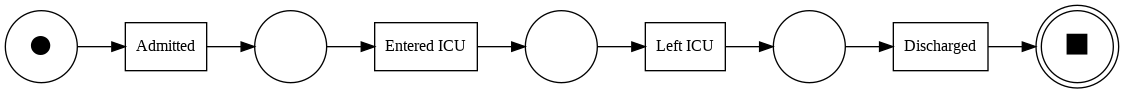

In [116]:
# format train event log as pm4py event log
train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
# petri net from heuristics miner
heuristic_net, heuristic_im, heuristic_fm = pm.discover_petri_net_heuristics(train_log)
pm.view_petri_net(heuristic_net, heuristic_im, heuristic_fm)

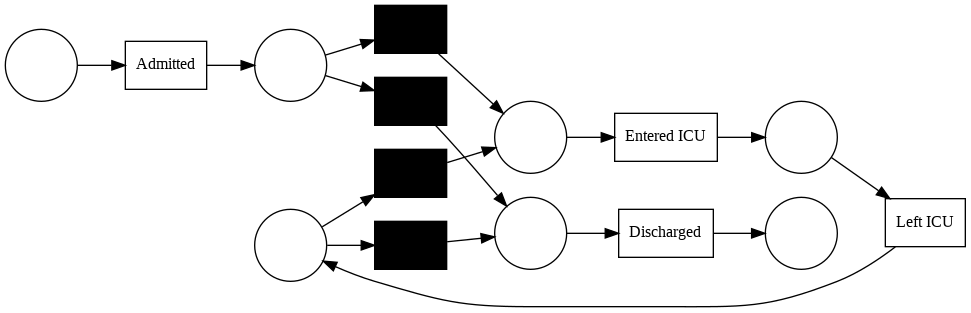

In [117]:
inductive_net, inductive_im, inductive_fm = pm.discover_petri_net_inductive(train_log)
pm.view_petri_net(petri_net=inductive_net)

<ipython-input-118-1ff381e6b524>:1: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. this method will be removed in a future release.
  alpha_net, alpha_im, alpha_fm = pm.discover_petri_net_alpha_plus(train_log)


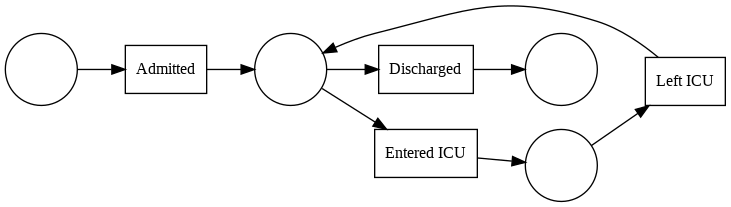

In [118]:
alpha_net, alpha_im, alpha_fm = pm.discover_petri_net_alpha_plus(train_log)
pm.view_petri_net(petri_net=alpha_net)

###4.2

In [119]:
def replay_trace(el, pn, im, fm):
  # log = pm.format_dataframe(el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
  replay_result_token = pm.fitness_token_based_replay(el, pn, im, fm, case_id_key='trace', activity_key='activity', timestamp_key='timestamp')
  replay_result_alignments = pm.fitness_alignments(el, pn, im, fm, case_id_key='trace', activity_key='activity', timestamp_key='timestamp')
  # print(replay_result_alignments)
  return replay_result_token['average_trace_fitness'], replay_result_alignments['average_trace_fitness']

In [120]:
def generate_traces(sequence, missing, trace, pn, im, fm):
    timestamps = sequence['timestamp'].tolist()
    if missing.iat[0,1] == 'Admitted':
      return pd.concat([missing,sequence], ignore_index=True), pd.concat([missing,sequence], ignore_index=True) 
    if missing.iat[0,1] == 'Discharged':
      return pd.concat([sequence,missing], ignore_index=True), pd.concat([sequence,missing], ignore_index=True)
     
    trace_length = len(timestamps) -1
    best_fitness_token = 0
    best_fitness_alignments = 0
    best_trace_token = None
    best_trace_alignments = None

    for i in range(1,trace_length+1):

      df = pd.concat([sequence.head(i), missing, sequence.tail(trace_length-i+1)], ignore_index=True)
      inputed_df = deepcopy(df)
      previous_timestamp = inputed_df.iat[i-1,2]
      next_timestamp = inputed_df.iat[i+1,2]
      inputed_timestamp = previous_timestamp + (next_timestamp-previous_timestamp)/2 
      inputed_df.iat[i,2] = inputed_timestamp
      # print(inputed_df)
      fitness_token, fitness_alignments = replay_trace(inputed_df, pn, im, fm)

      # fitness = 1
      if fitness_token > best_fitness_token:
        best_fitness_token = fitness_token
        best_trace_token = df
      
      if fitness_alignments > best_fitness_alignments:
        best_fitness_alignments = fitness_alignments
        best_trace_alignments = df


    return best_trace_token, best_trace_alignments


In [121]:
def predict_sequences(el, pn, im, fm):
  df_token = pd.DataFrame(columns=['trace','activity','timestamp'])
  df_alignments = pd.DataFrame(columns=['trace','activity','timestamp'])

  unique_traces = el['trace'].unique()

  for t in unique_traces:
    trace_df = el[:][test_el.trace == t]
    sequence = trace_df.loc[trace_df['timestamp'].notna()]
    missing = trace_df.loc[trace_df['timestamp'].isna()]
    # print(t)
    predicted_trace = generate_traces(sequence, missing, t, pn, im, fm)
    df_token = pd.concat([df_token,predicted_trace[0]], ignore_index=True)
    df_alignments = pd.concat([df_alignments, predicted_trace[1]], ignore_index=True)

  return df_token, df_alignments



In [122]:
alpha_sequences_token, alpha_sequences_alignments = predict_sequences(test_x, alpha_net, alpha_im, alpha_fm)
heuristic_sequences_token, heuristic_sequences_alignments = predict_sequences(test_x, heuristic_net, heuristic_im, heuristic_fm)
inductive_sequences_token, inductive_sequences_alignments = predict_sequences(test_x, inductive_net, inductive_im, inductive_fm)

###4.3 evaluate sequence prediction

In [123]:
def evaluate_sequences(predicted, targets):
  correct, incorrect, error = 0, 0, 0
  unique_traces = targets['trace'].unique()
  
  for trace in unique_traces:
    t = targets[:][targets.trace == trace]
    target = t.index[t['timestamp'].isnull()][0]
    p = predicted[:][predicted.trace == trace]
    prediction = p.index[p['timestamp'].isnull()][0]
    
    if prediction == target:
      correct += 1
    else:
      incorrect += 1
      error += (prediction - target)**2
    

  accuracy = correct / (correct + incorrect)
  rmse = (error / len(unique_traces)) ** 0.5

  return accuracy, rmse


print(f"Heuristic token based replay: {evaluate_sequences(test_x.reset_index(), heuristic_sequences_token.reset_index())}")
print(f"Inductive token based replay: {evaluate_sequences(test_x.reset_index(), inductive_sequences_token.reset_index())}")
print(f"Alpha token based replay: {evaluate_sequences(test_x.reset_index(), alpha_sequences_token.reset_index())}")

print(f"Heuristic alignments: {evaluate_sequences(test_x.reset_index(), heuristic_sequences_alignments.reset_index())}")
print(f"Inductive alignments: {evaluate_sequences(test_x.reset_index(), inductive_sequences_alignments.reset_index())}")
print(f"Alpha alignments: {evaluate_sequences(test_x.reset_index(), alpha_sequences_alignments.reset_index())}")





Heuristic token based replay: (1.0, 0.0)
Inductive token based replay: (1.0, 0.0)
Alpha token based replay: (1.0, 0.0)
Heuristic alignments: (0.9949238578680203, 0.21374114996372892)
Inductive alignments: (1.0, 0.0)
Alpha alignments: (1.0, 0.0)


###4.4 Finish pre-processing test data

In [133]:
def label_test(el):
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr, label_times_arr = [], [], [], [], [], []
  start_times, end_times = [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    df = el[:][el.trace == t]
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = df['timestamp'][i]
      # if pd.isnull(timestamp):
      timestamp =  df['timestamp'][i]
      timestamps.append(timestamp)
    
    # print(timestamps)

    length = len(timestamps)
    
    start_time = pd.NaT
    end_time = pd.NaT

    if not pd.isnull(timestamps[0]):
      start_time = timestamps[0]
      for i in range(length):
        if not pd.isnull(timestamps[i]):
          timestamps[i] = (timestamps[i] - start_time).total_seconds()  / 3600 / 1000

    order = 0
    for i in range(length):
      if pd.isnull(timestamps[i]):
        order = i
        break

    # print(order)

    label = activities[order]
    time_label = timestamps[order]
    prefix = activities[:order]
    prefix_times = timestamps[:order]

    # print(prefix_times)

    suffix, suffix_times = [], []

    if i != length - 1:
      suffix = activities[i+1:]
      suffix_times = timestamps[i+1:]

    padding = []

    while len(prefix) + len(padding) < PREFIX_LENGTH:
      padding.append('0')
    
    prefix = padding + prefix
      
    padding = []
    
    while len(prefix_times) + len(padding) < PREFIX_LENGTH:
      padding.append(0.0)
    
    prefix_times =  padding + prefix_times

    while len(suffix) < PREFIX_LENGTH:
      suffix.append('0')

    while len(suffix_times) < PREFIX_LENGTH:
      suffix_times.append(0.0)

    # f = '%Y-%d-%m %H:%M:%S'
    # for i in range(PREFIX_LENGTH):
    #   try:
    #     prefix_times[i] = pd.to_datetime(prefix_times[i], format=f).value
    #     # suffix_times[i] = pd.to_datetime(suffix_times[i], format=f).value
    #   except ValueError:
    #     continue

    # for i in range(PREFIX_LENGTH):
    #   try:
    #     # prefix_times[i] = pd.to_datetime(prefix_times[i], format=f).value
    #     suffix_times[i] = pd.to_datetime(suffix_times[i], format=f).value
    #   except ValueError:
    #     continue

    prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
    suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
    prefix_times_arr.append(np.array(prefix_times[:PREFIX_LENGTH], dtype=np.double))
    suffix_times_arr.append(np.array(suffix_times[:PREFIX_LENGTH], dtype=np.double))
    label_arr.append(label)
    label_times_arr.append(time_label)
    start_times.append(start_time)
    end_times.append(end_time)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix times' : prefix_times_arr,
                       'suffix times' : suffix_times_arr,
                       'activity label' : label_arr,
                       'time label': label_times_arr,
                       'start times': start_times,
                       'end times': end_times})


In [137]:
labeled_test = label_test(heuristic_sequences_token)
test_x, _, test_start_times = format_input(labeled_test)
labeled_test

,prefix,suffix,prefix times,suffix times,activity label,time label,start times,end times
0,"[1, 2, 3]","[0, 0, 0]","[0.0, 0.032211388888888894, 0.1022311111111111]","[0.0, 0.0, 0.0]",4,NaT,2196-12-02 12:00:00,NaT
1,"[0, 0, 1]","[3, 4, 0]","[0.0, 0.0, 0.0]","[0.12200777777777777, 0.19775, 0.0]",2,NaT,2165-09-13 07:15:00,NaT
2,"[0, 1, 2]","[4, 0, 0]","[0.0, 0.0, 0.005763333333333334]","[0.10905, 0.0, 0.0]",3,NaT,2182-06-06 07:15:00,NaT
3,"[0, 0, 1]","[3, 4, 0]","[0.0, 0.0, 0.0]","[0.0587575, 0.22188333333333332, 0.0]",2,NaT,2129-01-24 07:15:00,NaT
4,"[0, 1, 2]","[4, 0, 0]","[0.0, 0.0, 2.138888888888889e-05]","[0.21106666666666665, 0.0, 0.0]",3,NaT,2187-07-04 20:11:00,NaT
...,...,...,...,...,...,...,...,...
192,"[0, 0, 1]","[0, 0, 0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",4,NaT,2180-04-12 02:43:00,NaT
193,"[0, 0, 1]","[3, 4, 0]","[0.0, 0.0, 0.0]","[0.7427999999999999, 0.8409833333333333, 0.0]",2,NaT,2150-05-05 13:23:00,NaT
194,"[0, 0, 1]","[3, 4, 0]","[0.0, 0.0, 0.0]","[0.06407888888888888, 0.1584, 0.0]",2,NaT,2132-09-15 00:36:00,NaT
195,"[0, 0, 1]","[3, 4, 0]","[0.0, 0.0, 0.0]","[0.07741972222222222, 0.1201, 0.0]",2,NaT,2164-01-05 16:38:00,NaT


In [138]:
test_start_times

array(['2196-12-02T12:00:00.000000000', '2165-09-13T07:15:00.000000000',
       '2182-06-06T07:15:00.000000000', '2129-01-24T07:15:00.000000000',
       '2187-07-04T20:11:00.000000000', '2181-12-19T20:08:00.000000000',
       '2125-08-16T09:30:00.000000000', '2190-09-08T07:15:00.000000000',
       '2147-12-08T06:46:00.000000000', '2191-12-11T00:20:00.000000000',
       '2107-01-10T22:02:00.000000000', '2187-02-08T18:12:00.000000000',
       '2152-08-27T02:08:00.000000000', '2139-04-20T11:45:00.000000000',
       '2136-07-24T14:00:00.000000000', '2200-03-18T18:11:00.000000000',
       '2125-06-14T19:26:00.000000000', '2187-02-04T17:40:00.000000000',
       '2148-09-04T20:06:00.000000000', '2191-08-23T13:03:00.000000000',
       '2193-03-28T18:34:00.000000000', '2123-01-25T16:04:00.000000000',
       '2163-01-01T09:05:00.000000000', '2167-02-15T14:38:00.000000000',
       '2173-02-11T14:44:00.000000000', '2175-11-20T09:01:00.000000000',
       '2149-12-16T08:43:00.000000000', '2160-03-23

##Section 5: Naiive timestamp imputation method

In [ ]:
# calculate mean time delta for discharge and admission
def admission_discharge_delta(el):
  discharge_delta, admission_delta = 0, 0
  unique_traces = el['trace'].unique()
  n = len(unique_traces)

  for t in unique_traces:
    df = el[:][el.trace == t]
    timestamps = [], []

    for i in df.index:
      timestamp = (df['timestamp'][i]).total_seconds()
      timestamps.append(timestamp)
    
    admission_delta += timestamps[1] - timestamps[0]
    discharge_delta += timestamps[-1] - timestamps[-2]

  mean_admission_delta = admission_delta/n
  mean_discharge_delta = discharge_delta/n


  # return 

  


admission_discharge_delta(train_x)

In [145]:
def naiive(p, s):
  predictions = []
  for i in range(len(p)):
    # print(i,':')
    # print(p[i][-1])
    # print(start_time + pd.to_timedelta(p[i][-1] * 10_000_000_000, unit='s'))
    # print(s[i][0])
    # print(start_time + pd.to_timedelta(s[i][0] * 10_000_000_000, unit='s'))

    if p[i][-1] != 0.0 and s[i][0] != 0:
      prediction = p[i][-1] + (s[i][0] - p[i][-1])/2
      seconds = test_start_times[i] + pd.to_timedelta(prediction * 3600 * 1000, unit='s')
      predictions.append(seconds)
    else:
      predictions.append(-1)

  return predictions
    
naiive_predictions = naiive(test_x[2], test_x[3])

In [ ]:
# def evaluate

## Section 6: Predicting timestamp using LSTM 

In [139]:
from keras.layers import Dropout, Input, Bidirectional, LSTM, average, Dense, concatenate
from keras import Model

prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_times_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_times_input')
suffix_times_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_times_input')

lstm_layer = LSTM(96)

prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
prefix_times_lstm = Bidirectional(lstm_layer, name='prefix_times_lstm')(prefix_times_input)
suffix_times_lstm = Bidirectional(lstm_layer, name='suffix_times_lstm')(suffix_times_input)


dropout_prefix_events = Dropout(0)(prefix_events_lstm)
dropout_suffix_events = Dropout(0)(suffix_events_lstm)
dropout_prefix_times = Dropout(0)(prefix_times_lstm)
dropout_suffix_times = Dropout(0)(suffix_times_lstm)


merged = concatenate([dropout_prefix_events, dropout_suffix_events, dropout_prefix_times, dropout_suffix_times], name='merged')
# merged = concatenate([dropout_prefix_times, dropout_suffix_times], name='merged')


output = Dense(1, name='output')(merged)

best_model = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_times_input, suffix_times_input],
    # inputs=[prefix_times_input, suffix_times_input],

    outputs=output)
best_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
best_model.summary()
best_model.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    # (train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
    # validation_data=((validation_x[2], validation_x[3]),
                     validation_y), epochs=10)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 3, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 3, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_times_input (InputLayer  [(None, 3, 1)]      0           []                               
 )                                                                                          

##Section 7: Evaluating the model

In [147]:
def mean_squared_error(predictions):
  seconds, minutes, hours, days = 0, 0, 0, 0
  for p, t in zip(predictions, test_y):
    if p != -1:
      seconds += (p-t).total_seconds() ** 2
  seconds = (seconds / len(predictions)) ** 0.5
  minutes = seconds / 60
  hours = minutes / 60
  days = hours / 24
  years = days / 365
  
  return seconds, minutes, hours, days, years


In [142]:
def predict(model):
  predictions = model.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
  predicted_times = []
  for i in range(len(predictions)):
    seconds = test_start_times[i] + pd.to_timedelta(predictions[i] * 3600 * 1000, unit='s')
    predicted_times.append(seconds)
  return predicted_times
predictions = predict(best_model)

7/7 [==============================] - 4s 9ms/step


In [148]:
mean_squared_error(predictions)

(Float64Index([551489.4444241604], dtype='float64'),
 Float64Index([9191.490740402673], dtype='float64'),
 Float64Index([153.19151234004454], dtype='float64'),
 Float64Index([6.382979680835189], dtype='float64'),
 Float64Index([0.017487615563932024], dtype='float64'))

In [149]:
mean_squared_error(naiive_predictions)

(Float64Index([311820.0870856019], dtype='float64'),
 Float64Index([5197.001451426698], dtype='float64'),
 Float64Index([86.61669085711164], dtype='float64'),
 Float64Index([3.609028785712985], dtype='float64'),
 Float64Index([0.009887750097843795], dtype='float64'))